In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
pois_shapefile_path = "../data/raw/greater-london-latest-free.shp/gis_osm_pois_free_1.shp"
gdf_pois = gpd.read_file(pois_shapefile_path)

In [7]:
business_fclasses  = [
    'pharmacy', 'doctors', 'dentist', 'theatre', 'nightclub', 'cinema', 'sports_centre', # leisure category
    'restaurant', 'fast_food', 'cafe', 'pub', 'bar', 'food_court', 'biergarten', # catering
    'hotel', 'motel', 'bed_and_breakfast', 'guesthouse', 'hostel', 'chalet', # accommodation
    'supermarket', 'bakery', 'kiosk', 'mall', 'department_store', 'general', # shopping
    'convenience', 'clothes', 'florist', 'chemist', 'bookshop', 'butcher', 
    'shoe_shop', 'beverages', 'optician', 'jeweller', 'gift_shop', 'sports_shop',
    'stationery', 'outdoor_shop', 'mobile_phone_shop', 'toy_shop', 'newsagent',
    'greengrocer', 'beauty_shop', 'video_shop', 'car_dealership', 'bicycle_shop',
    'doityourself', 'furniture_shop', 'computer_shop', 'garden_centre',
    'hairdresser', 'car_repair', 'car_rental', 'car_wash', 'car_sharing', 
    'bicycle_rental', 'travel_agent', 'laundry',
    'bank', 'atm', # money
]

In [8]:
print(len(business_fclasses))

62


In [9]:
# Example 3: Extract businesses based on a list of fclass types relevant to "business"
# You'll need to consult the PDF to create a comprehensive list of fclass values
# that you consider "businesses" (e.g., shops, offices, specific amenities).
# The 'pois' layer includes categories for shopping, catering, accommodation etc. [cite: 56, 61]

business_fclasses  = [
    'pharmacy', 'doctors', 'dentist', 'theatre', 'nightclub', 'cinema', 'sports_centre', # leisure category
    'restaurant', 'fast_food', 'cafe', 'pub', 'bar', 'food_court', 'biergarten', # catering
    'hotel', 'motel', 'bed_and_breakfast', 'guesthouse', 'hostel', 'chalet', # accommodation
    'supermarket', 'bakery', 'kiosk', 'mall', 'department_store', 'general', # shopping
    'convenience', 'clothes', 'florist', 'chemist', 'bookshop', 'butcher', 
    'shoe_shop', 'beverages', 'optician', 'jeweller', 'gift_shop', 'sports_shop',
    'stationery', 'outdoor_shop', 'mobile_phone_shop', 'toy_shop', 'newsagent',
    'greengrocer', 'beauty_shop', 'video_shop', 'car_dealership', 'bicycle_shop',
    'doityourself', 'furniture_shop', 'computer_shop', 'garden_centre',
    'hairdresser', 'car_repair', 'car_rental', 'car_wash', 'car_sharing', 
    'bicycle_rental', 'travel_agent', 'laundry',
    'bank', 'atm', # money
]

# Filter for multiple types of businesses
all_businesses = gdf_pois[gdf_pois['fclass'].isin(business_fclasses)]
print(f"Found {len(all_businesses)} businesses based on the defined list.")
# print(all_businesses.head())

Found 39688 businesses based on the defined list.


In [10]:
all_businesses.head()

,osm_id,code,fclass,name,geometry
1,108539,2566,bicycle_rental,Windsor Terrace,POINT (-0.09339 51.52913)
3,451152,2304,pub,King of Prussia,POINT (-0.19461 51.60084)
4,451153,2301,restaurant,Central Restaurant,POINT (-0.1935 51.60203)
5,451154,2304,pub,The Catcher in the Rye,POINT (-0.19603 51.59958)
6,451271,2304,pub,The Tally Ho,POINT (-0.17656 51.6141)


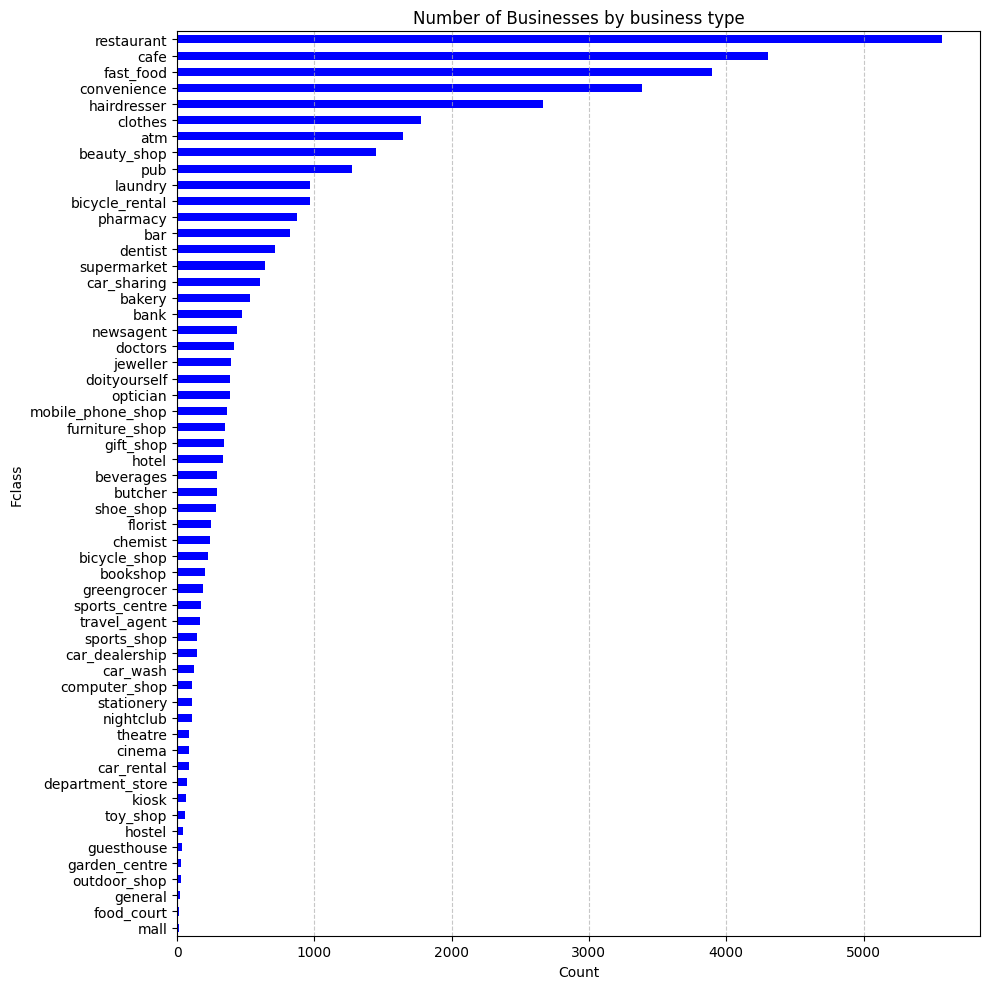

In [11]:
# plot a horizontal bar chart of the number of businesses by fclass
business_counts = all_businesses['fclass'].value_counts()
business_counts = business_counts[business_counts > 10]  # Filter out fclasses with less than 10 occurrences
business_counts = business_counts.sort_values(ascending=True)  # Sort by count
plt.figure(figsize=(10, 10))
business_counts.plot(kind='barh', color='blue')
plt.title('Number of Businesses by business type')
plt.xlabel('Count')
plt.ylabel('Fclass')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('../figures/businesses_by_type.png', dpi=300)
plt.show()

In [12]:
roads_shp_path = "../data/raw/greater-london-latest-free.shp/gis_osm_roads_free_1.shp"
gdf_roads = gpd.read_file(roads_shp_path)
# Ensure roads also have the same CRS
# if gdf_roads.crs is None:
#     gdf_roads = gdf_roads.set_crs("EPSG:4326", allow_override=True)
# elif gdf_roads.crs != all_businesses.crs:
#     gdf_roads = gdf_roads.to_crs(all_businesses.crs)

# Perform a spatial join to find the nearest road.
# sjoin_nearest works best if your GeoPandas is version 0.10.0 or later.
# 'left' join keeps all businesses, finding the nearest road for each.
# 'max_distance' can be used to limit search radius (e.g., in meters if CRS is projected,
# or degrees if EPSG:4326 - be careful with degrees for distance)
# For EPSG:4326, a small degree value like 0.001 (approx 100m) might be a starting point.
# It's often better to reproject to a suitable projected CRS for distance-based operations.

# Reproject to a projected CRS for accurate distance (e.g., UTM zone for London)
# For London, a common UTM zone is EPSG:32630 (WGS 84 / UTM zone 30N)
all_businesses_proj = all_businesses.to_crs("EPSG:32630")
gdf_roads_proj = gdf_roads.to_crs("EPSG:32630")

businesses_with_streets = gpd.sjoin_nearest(
    all_businesses_proj,
    gdf_roads_proj[['geometry', 'name']], # Select only relevant columns from roads
    how='left',
    max_distance=100, # Max distance in CRS units (meters for EPSG:32630)
    lsuffix='business', # Suffix for overlapping column names from left GDF
    rsuffix='road'      # Suffix for overlapping column names from right GDF
)
# Rename the street name column if needed (it might be 'name_road')
if 'name_road' in businesses_with_streets.columns:
    businesses_with_streets = businesses_with_streets.rename(columns={'name_road': 'street_name'})
# Drop the index_road column if you don't need it
if 'index_road' in businesses_with_streets.columns:
    businesses_with_streets = businesses_with_streets.drop(columns=['index_road'])

# Convert back to original CRS if needed
businesses_with_streets = businesses_with_streets.to_crs(all_businesses.crs)
print("Street names added (or attempted).")
# print(businesses_with_streets.head())
all_businesses = businesses_with_streets.copy() # Update your main dataframe


Street names added (or attempted).


In [13]:
all_businesses

,osm_id,code,fclass,name_business,geometry,street_name
1,108539,2566,bicycle_rental,Windsor Terrace,POINT (-0.09339 51.52913),Windsor Terrace
3,451152,2304,pub,King of Prussia,POINT (-0.19461 51.60084),Dollis Park
4,451153,2301,restaurant,Central Restaurant,POINT (-0.1935 51.60203),Nether Street
5,451154,2304,pub,The Catcher in the Rye,POINT (-0.19603 51.59958),Regent's Park Road
6,451271,2304,pub,The Tally Ho,POINT (-0.17656 51.6141),None
...,...,...,...,...,...,...
94351,12818896780,2303,cafe,Station Coffee,POINT (-0.20501 51.53416),None
94352,12819770592,2304,pub,The Crown,POINT (0.00473 51.48505),Woodland Walk
94357,12820888010,2301,restaurant,Kish,POINT (-0.24901 51.51347),Old Oak Common Lane
94358,12821116746,2120,doctors,Central Park Surgery,POINT (0.05022 51.53258),Barking Road


In [14]:
all_businesses.to_csv("../data/processed/businesses_with_streets.csv", index=False)

In [15]:
places_shp_path = "../data/raw/greater-london-latest-free.shp/gis_osm_places_free_1.shp"
gdf_places = gpd.read_file(places_shp_path)

In [16]:
gdf_places.head()

,osm_id,code,fclass,population,name,geometry
0,107775,1005,national_capital,8908083,London,POINT (-0.12777 51.50745)
1,196021,1010,suburb,0,Whetstone,POINT (-0.17488 51.63019)
2,198806,1010,suburb,0,Totteridge,POINT (-0.20087 51.63313)
3,200088,1010,suburb,0,Friern Barnet,POINT (-0.15859 51.61288)
4,201212,1010,suburb,0,Muswell Hill,POINT (-0.14208 51.59104)


In [17]:
borough_boundaries = gpd.read_file('../data/raw/gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
borough_boundaries = borough_boundaries.rename(columns={'NAME': 'area'})
borough_boundaries = borough_boundaries.to_crs(all_businesses.crs) # Ensure same CRS
borough_boundaries.head()

,area,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((-0.06402 51.31864, -0.06408 51.31861..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((0.01213 51.2996, 0.01196 51.2998, 0...."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((-0.24456 51.4887, -0.24468 51.48868,..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((-0.41183 51.53408, -0.41188 51.53412..."


In [18]:
# add borough names to the businesses
businesses_with_boroughs = gpd.sjoin(
    all_businesses,
    borough_boundaries[['geometry', 'area']], # Select only relevant columns from boroughs
    how='left',
    predicate='intersects', # Use 'intersects' for spatial join
    lsuffix='business', # Suffix for overlapping column names from left GDF
    rsuffix='borough'   # Suffix for overlapping column names from right GDF
)

In [19]:
businesses_with_boroughs.to_csv("../data/processed/businesses_with_boroughs.csv", index=False)

In [20]:
businesses_with_boroughs.head(10)

,osm_id,code,fclass,name_business,geometry,street_name,index_borough,area
1,108539,2566,bicycle_rental,Windsor Terrace,POINT (-0.09339 51.52913),Windsor Terrace,28.0,Hackney
3,451152,2304,pub,King of Prussia,POINT (-0.19461 51.60084),Dollis Park,9.0,Barnet
4,451153,2301,restaurant,Central Restaurant,POINT (-0.1935 51.60203),Nether Street,9.0,Barnet
5,451154,2304,pub,The Catcher in the Rye,POINT (-0.19603 51.59958),Regent's Park Road,9.0,Barnet
6,451271,2304,pub,The Tally Ho,POINT (-0.17656 51.6141),None,9.0,Barnet
11,12242503,2304,pub,Railway Bell,POINT (0.02796 51.59202),Mulberry Way,17.0,Redbridge
18,15262028,2304,pub,The Monkey Puzzle,POINT (-0.16983 51.51648),None,24.0,Westminster
23,18235090,2304,pub,The Arab Boy,POINT (-0.2267 51.46286),Upper Richmond Road,21.0,Wandsworth
24,20821133,2304,pub,The Union Bar,POINT (-0.17774 51.50042),Jay Mews,24.0,Westminster
26,20849687,2303,cafe,None,POINT (-0.33402 51.41101),None,19.0,Richmond upon Thames


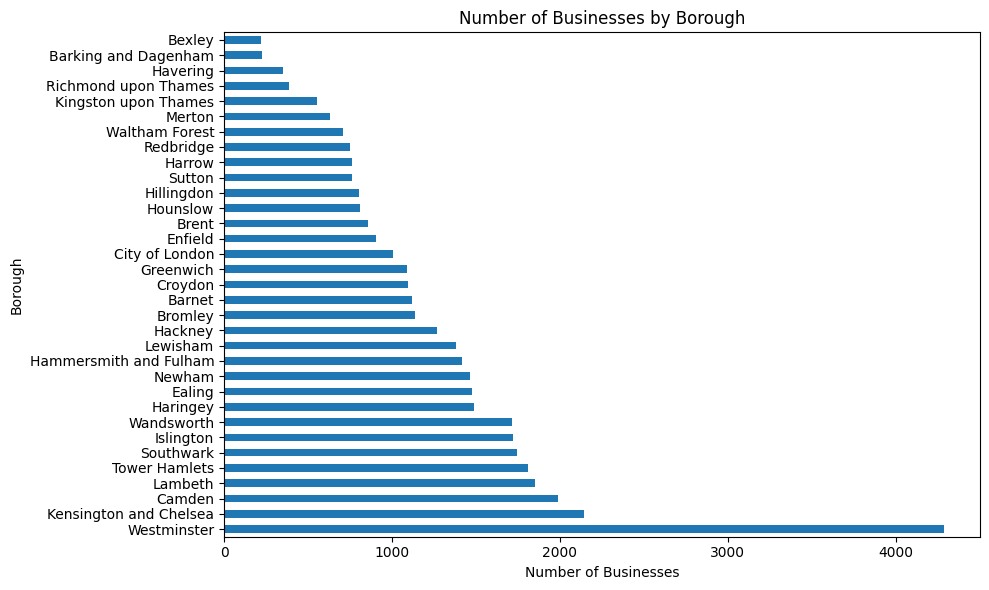

In [25]:
# plot number of businesses by borough and type of businesses as colors in a stacked bar chart
businesses_with_boroughs['area'].value_counts().plot(kind='barh', figsize=(10, 6))
plt.title('Number of Businesses by Borough')
plt.xlabel('Number of Businesses')
plt.ylabel('Borough')
plt.tight_layout()
plt.savefig('../figures/businesses_by_borough.png', dpi=300)
plt.show()


In [ ]:
# Count number of nans in the area column
nan_count = businesses_with_boroughs['area'].isna().sum()
print(f"Number of businesses without borough information: {nan_count}")